In [1]:
from edge_sensor.sdr import airt
import labbench as lb

lb.show_messages('debug')
sdr = airt.AirTSource()

In [2]:
sdr.open()

 DEBUG  2024-07-02 11:13:21,914.915 • AirTSource(): connecting
 DEBUG  2024-07-02 11:13:27,818.818 • AirTSource(): connected
 DEBUG  2024-07-02 11:13:35,225.225 • AirTSource(): opened


In [3]:
# sdr.autosample(3710e6, 15.36e6, 10e6, lo_shift='left')
# sdr.analysis_filter

In [4]:
from edge_sensor.config import Capture

capture = Capture(duration=0.1)

try:
    count = sdr.configure(capture)
    iq = sdr.acquire(count)
finally:
    sdr.channel_enabled(False, channel=0)

 DEBUG  2024-07-02 11:13:37,071.071 • AirTSource(): True  → channel_enabled
 DEBUG  2024-07-02 11:13:37,273.274 • AirTSource(): 20833333.333333332 (Hz) → sample_rate
 DEBUG  2024-07-02 11:13:37,276.277 • AirTSource(): 20833333.333333332 (Hz) → backend_sample_rate
 DEBUG  2024-07-02 11:13:37,280.280 • AirTSource(): 15360000.0 (Hz) → sample_rate
 DEBUG  2024-07-02 11:13:37,282.282 • AirTSource(): 10000000.0 (Hz) → analysis_bandwidth
 DEBUG  2024-07-02 11:13:39,298.298 • AirTSource(): False  → channel_enabled


In [5]:
import importlib

from channel_analysis import config
config = importlib.reload(config)

from channel_analysis import waveform
waveform = importlib.reload(waveform)
waveform.config = config

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
        'truncate': True
    },
    'amplitude_probability_distribution': {
        'power_low': -105,
        'power_high': -60,
        'power_count': 221,  # 0.25 dB resolution
    },
    # 'iq_waveform': {
    #     'start_time_sec': 0,
    #     'stop_time_sec': 100e-3
    # }
}

filter_spec = {}

dataset = waveform.from_spec(
    iq,
    sdr,
    analysis_spec=analysis_spec,
)

 DEBUG  2024-07-02 11:14:13,840.840 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:13,879.880 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:13,903.903 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:14,710.710 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:14,712.713 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:14,717.717 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:16,860.860 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:16,863.863 • AirTSource(): sample_rate → 15359999.999999998  (Hz)
 DEBUG  2024-07-02 11:14:16,881.882 • AirTSource(): sample_rate → 15359999.999999998  (Hz)


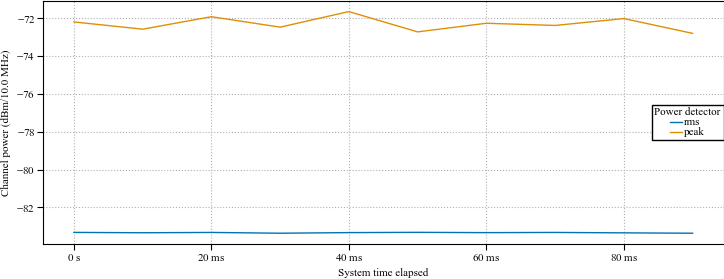

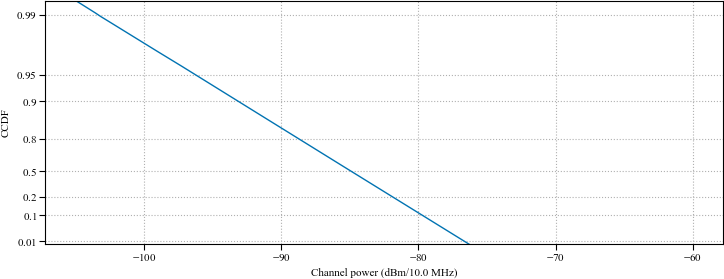

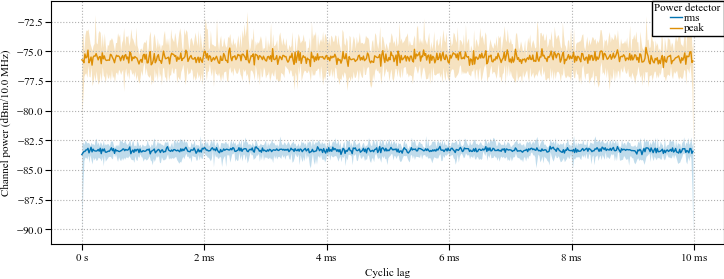

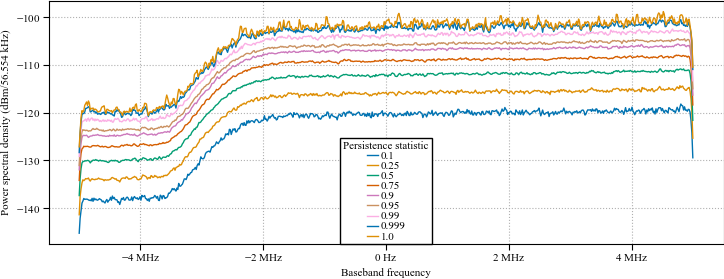

In [6]:
import iqwaveform
from channel_analysis import figures
import matplotlib.pyplot as plt
from iqwaveform import powtodB

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
pvt = dataset.power_time_series
pvt.plot.line(x='time_elapsed', ax=ax)
figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

fig, ax = plt.subplots()
apd = dataset.amplitude_probability_distribution
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

fig, ax = plt.subplots()
cyclic_power = dataset.cyclic_channel_power
time = cyclic_power.cyclic_lag
for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

fig, ax = plt.subplots()
spectrum = dataset.persistence_spectrum
spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')